# House Prices - Advanced Regression Techniques

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time, warnings, itertools
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from scipy.stats import norm
from scipy import stats

# ignore warning messages
warnings.filterwarnings('ignore')

# Data Exploration

## File Descriptions
- `train.csv` - the training set
- `test.csv` - the test set
- `data_description.txt` - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here
- `sample_submission.csv` - a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

## Data Fields

- `Target`
    - ***SalePrice*** - the property's sale price in dollars. This is the target variable that you're trying to predict.
- `Features`
    - ***MSSubClass***: The building class
    - ***MSZoning***: The general zoning classification
    - ***LotFrontage***: Linear feet of street connected to property
    - ***LotArea***: Lot size in square feet
    - ***Street***: Type of road access
    - ***Alley***: Type of alley access
    - ***LotShape***: General shape of property
    - ***LandContour***: Flatness of the property
    - ***Utilities***: Type of utilities available
    - ***LotConfig***: Lot configuration
    - ***LandSlope***: Slope of property
    - ***Neighborhood***: Physical locations within Ames city limits
    - ***Condition1***: Proximity to main road or railroad
    - ***Condition2***: Proximity to main road or railroad (if a second is present)
    - ***BldgType***: Type of dwelling
    - ***HouseStyle***: Style of dwelling
    - ***OverallQual***: Overall material and finish quality
    - ***OverallCond***: Overall condition rating
    - ***YearBuilt***: Original construction date
    - ***YearRemodAdd***: Remodel date
    - ***RoofStyle***: Type of roof
    - ***RoofMatl***: Roof material
    - ***Exterior1st***: Exterior covering on house
    - ***Exterior2nd***: Exterior covering on house (if more than one material)
    - ***MasVnrType***: Masonry veneer type
    - ***MasVnrArea***: Masonry veneer area in square feet
    - ***ExterQual***: Exterior material quality
    - ***ExterCond***: Present condition of the material on the exterior
    - ***Foundation***: Type of foundation
    - ***BsmtQual***: Height of the basement
    - ***BsmtCond***: General condition of the basement
    - ***BsmtExposure***: Walkout or garden level basement walls
    - ***BsmtFinType1***: Quality of basement finished area
    - ***BsmtFinSF1***: Type 1 finished square feet
    - ***BsmtFinType2***: Quality of second finished area (if present)
    - ***BsmtFinSF2***: Type 2 finished square feet
    - ***BsmtUnfSF***: Unfinished square feet of basement area
    - ***TotalBsmtSF***: Total square feet of basement area
    - ***Heating***: Type of heating
    - ***HeatingQC***: Heating quality and condition
    - ***CentralAir***: Central air conditioning
    - ***Electrical***: Electrical system
    - ***1stFlrSF***: First Floor square feet
    - ***2ndFlrSF***: Second floor square feet
    - ***LowQualFinSF***: Low quality finished square feet (all floors)
    - ***GrLivArea***: Above grade (ground) living area square feet
    - ***BsmtFullBath***: Basement full bathrooms
    - ***BsmtHalfBath***: Basement half bathrooms
    - ***FullBath***: Full bathrooms above grade
    - ***HalfBath***: Half baths above grade
    - ***Bedroom***: Number of bedrooms above basement level
    - ***Kitchen***: Number of kitchens
    - ***KitchenQual***: Kitchen quality
    - ***TotRmsAbvGrd***: Total rooms above grade (does not include bathrooms)
    - ***Functional***: Home functionality rating
    - ***Fireplaces***: Number of fireplaces
    - ***FireplaceQu***: Fireplace quality
    - ***GarageType***: Garage location
    - ***GarageYrBlt***: Year garage was built
    - ***GarageFinish***: Interior finish of the garage
    - ***GarageCars***: Size of garage in car capacity
    - ***GarageArea***: Size of garage in square feet
    - ***GarageQual***: Garage quality
    - ***GarageCond***: Garage condition
    - ***PavedDrive***: Paved driveway
    - ***WoodDeckSF***: Wood deck area in square feet
    - ***OpenPorchSF***: Open porch area in square feet
    - ***EnclosedPorch***: Enclosed porch area in square feet
    - ***3SsnPorch***: Three season porch area in square feet
    - ***ScreenPorch***: Screen porch area in square feet
    - ***PoolArea***: Pool area in square feet
    - ***PoolQC***: Pool quality
    - ***Fence***: Fence quality
    - ***MiscFeature***: Miscellaneous feature not covered in other categories
    - ***MiscVal***: $Value of miscellaneous feature
    - ***MoSold***: Month Sold
    - ***YrSold***: Year Sold
    - ***SaleType***: Type of sale
    - ***SaleCondition***: Condition of sale

In [6]:
# Load Data
training_data = pd.read_csv('train.csv')

test_data = pd.read_csv('test.csv')

### Exploring Training Data

In [7]:
training_data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [9]:
# Shape of Training Data
training_data.shape

(1460, 81)

In [30]:
# Descriptive Statistics Summary of SalesPrice
training_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


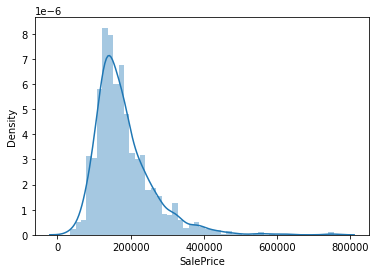

In [33]:
# SalePrice Histogram
sns.distplot(training_data['SalePrice'])

#SalePrice's Skewness and kurtosis
print(f"Skewness: {training_data['SalePrice'].skew()}")
print(f"Kurtosis: {training_data['SalePrice'].kurt()}")

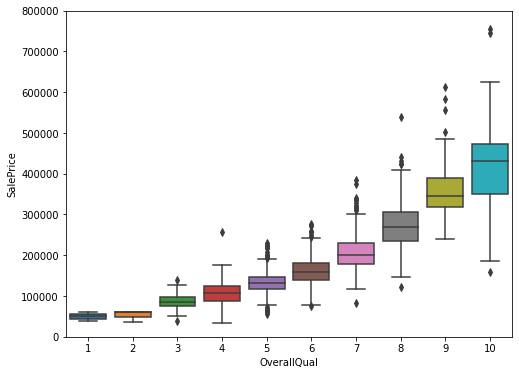

In [36]:
# Box Plot OverallQual/SalePrice
var = 'OverallQual'
data = pd.concat([training_data['SalePrice'], training_data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

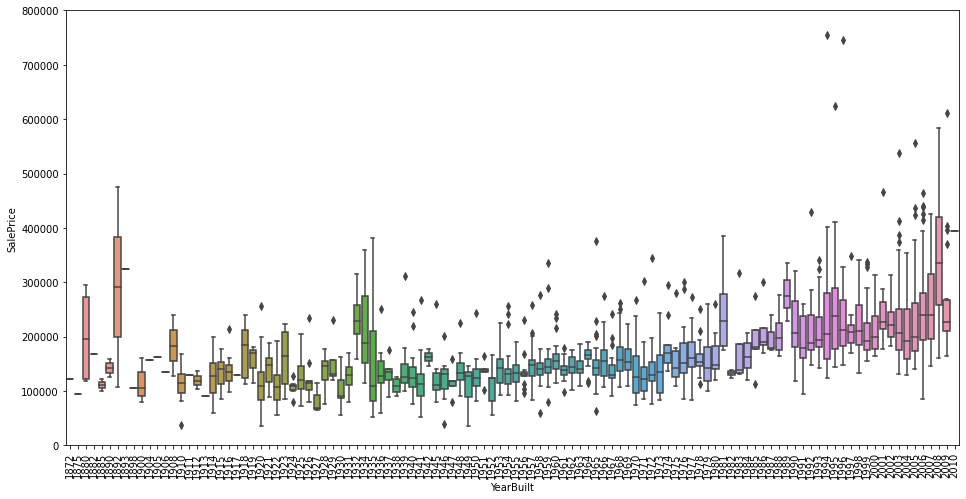

In [39]:
# Box Plot YearBuilt/SalePrice
data = pd.concat([training_data['SalePrice'], training_data['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='YearBuilt', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

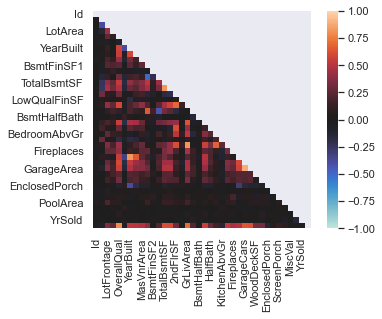

In [47]:
matrix = np.triu(training_data.corr())
sns.heatmap(training_data.corr(), square=True, vmin=-1, vmax=1, center=0, mask=matrix);

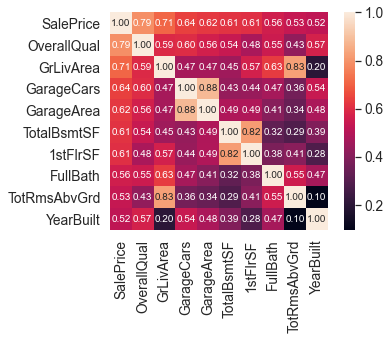

In [44]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = training_data.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(training_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

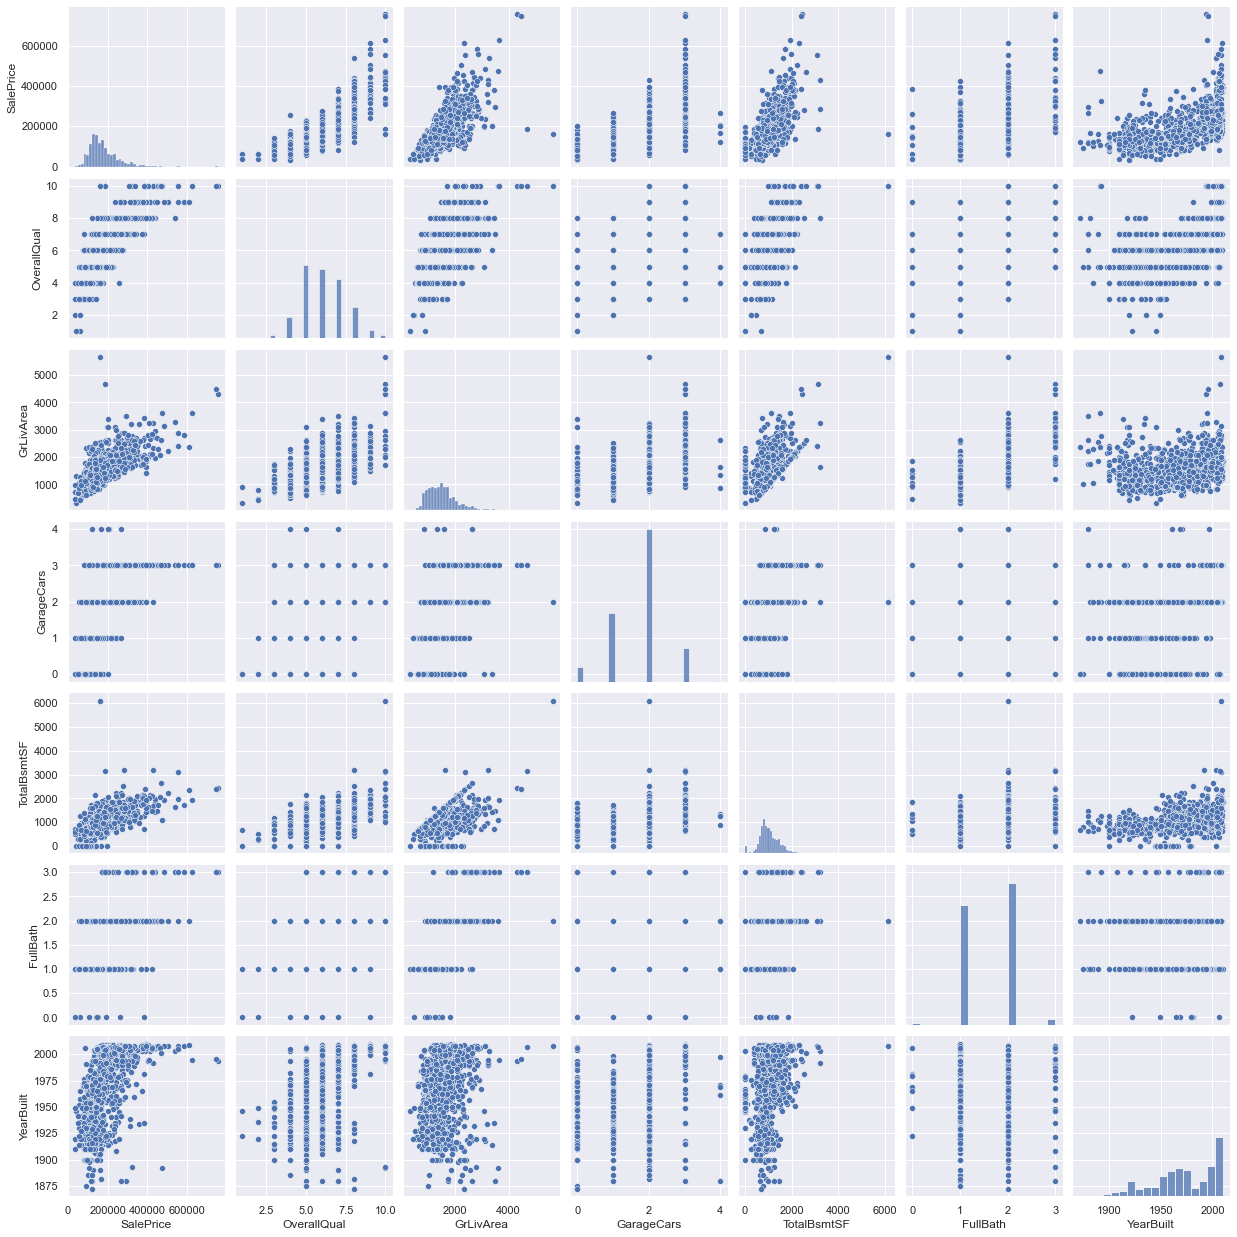

In [46]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(training_data[cols], size = 2.5)
plt.show();

## Sources
1.) https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python